# Vascular, Extracellular and Restricted Diffusion for Cytometry in Tumors (VERDICT)

Panagiotaki et al. (2014) proposed a multi-compartment model called VERDICT to characterize the composition of tumorous tissues. VERDICT models the diffusion in tumor cells, the extra-cellular space and surrounding bloodvessels as a restricted Sphere, an isotropic Gaussian Ball and a Stick compartment, respectively. VERDICT's design is as follows:
\begin{equation}
 E_{\textrm{VERDICT}}= \underbrace{f_{\textrm{Tumor}}\overbrace{E(D|\lambda_{\textrm{intra}})}^{\textrm{Sphere}}}_{\textrm{Tumor Cells}} + \underbrace{f_{\textrm{extra}}\overbrace{E(\cdot|\lambda_{iso})}^{\textrm{Ball}}}_{\textrm{Hindered Extra-Cellular}}+\underbrace{f_{blood}\overbrace{E(\lambda_\parallel, \boldsymbol{\mu})}^{\textrm{Stick}}}_{\textrm{Vascular}}
\end{equation}
where $D$ is the sphere's diameter. VERDICT uses the Gaussian Phase approximation to model the sphere *(Balinov et al. 1993)*, which accounts to changes in gradient pulse duration $\delta$ and separation $\Delta$. Furthermore, some particular parameter constraints are imposed:
- The intra-cellular (intra-spherical) diffusivity is fixed to 0.9e-9 m^2/s
- The extra-cellular Gaussian diffusivity is also fixed to 0.9e-9 m^2/s
- The optimization range for $\lambda_\parallel$ of the Vascular Stick is set between (3.05-10)e-9 m^2/s

We can define the VERDICT model in the following lines of code:

# Using Dmipy to set up the VERDICT model

We first load the necessary modules to import the Sphere, Ball, and Stick models.

In [1]:
from dmipy.signal_models import sphere_models, cylinder_models, gaussian_models

/home/rutger/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


The Sphere model must be initiated with VERDICT's setting for intra-spherical diffusivity, while the Ball and Stick model are regularly imported.

In [2]:
sphere = sphere_models.S4SphereGaussianPhaseApproximation(diffusion_constant=0.9e-9)
ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()

We then assemble the three models into a multi-compartment model:

In [3]:
from dmipy.core.modeling_framework import MultiCompartmentModel
verdict_mod = MultiCompartmentModel(models=[sphere, ball, stick])
verdict_mod.parameter_names

['G1Ball_1_lambda_iso',
 'S4SphereGaussianPhaseApproximation_1_diameter',
 'C1Stick_1_mu',
 'C1Stick_1_lambda_par',
 'partial_volume_0',
 'partial_volume_1',
 'partial_volume_2']

Visualize the model:

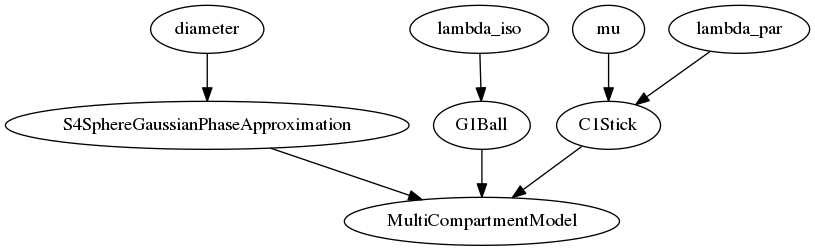

In [4]:
from IPython.display import Image
verdict_mod.visualize_model_setup(view=False, cleanup=False, with_parameters=True)
Image('Model Setup.png')

We then fix the Ball's diffusivity, and adjust the Stick's optimization range for $\lambda_\parallel$  for the optimization.

In [5]:
verdict_mod.set_fixed_parameter('G1Ball_1_lambda_iso', 0.9e-9)
verdict_mod.set_parameter_optimization_bounds(
    'C1Stick_1_lambda_par', [3.05e-9, 10e-9])

We are now ready to fit the data.

# Fitting VERDICT to UCL Example Data

As illustration data we use the voxel of VERDICT data that is freely available at the UCL website at http://camino.cs.ucl.ac.uk/index.php?n=Tutorials.VERDICTcol. We prepared the script to easily import the acquisition scheme and example data from there:

In [6]:
from dmipy.data import saved_data
scheme, data = saved_data.panagiotaki_verdict()
scheme.print_acquisition_info

Acquisition scheme summary

total number of measurements: 220
number of b0 measurements: 49
number of DWI shells: 41

shell_index |# of DWIs |bvalue [s/mm^2] |gradient strength [mT/m] |delta [ms] |Delta[ms] |TE[ms]
0           |19        |20              |0                        |3.0        |10.0      |17.0 
1           |3         |148             |160                      |3.0        |10.0      |17.0 
2           |3         |231             |200                      |3.0        |10.0      |17.0 
3           |3         |333             |240                      |3.0        |10.0      |17.0 
4           |3         |454             |280                      |3.0        |10.0      |17.0 
5           |3         |593             |320                      |3.0        |10.0      |17.0 
6           |3         |751             |360                      |3.0        |10.0      |17.0 
7           |3         |927             |400                      |3.0        |10.0      |17.0 
8           |12  

We can see that the VERDICT acquisition scheme is very particular, having many shells with different diffusion times and often only 3 perpendicular measurements per shell, with the exception of one DTI shell with 42 measurements.

To fit the data we use the MIX algorithm *(Farooq et al. 2016)*, which is efficient for finding the global minimum in models with many compartments. We set parallel processing to False since there is only one voxel.

In [7]:
verdict_fit = verdict_mod.fit(scheme, data, solver='mix', use_parallel_processing=False)

Setup MIX optimizer in 2.90870666504e-05 seconds
Fitting of 1 voxels complete in 3.41024303436 seconds.
Average of 3.41024303436 seconds per voxel.


# Visualize results

To illustrate that Dmipy's VERDICT implementation is correct, we show that we can produce a very similar signal fitting plots as the one shown on the UCL website. On the left we show their original graph, and on the right we show Dmipy's predicted signal together with the measured signal attenuation.

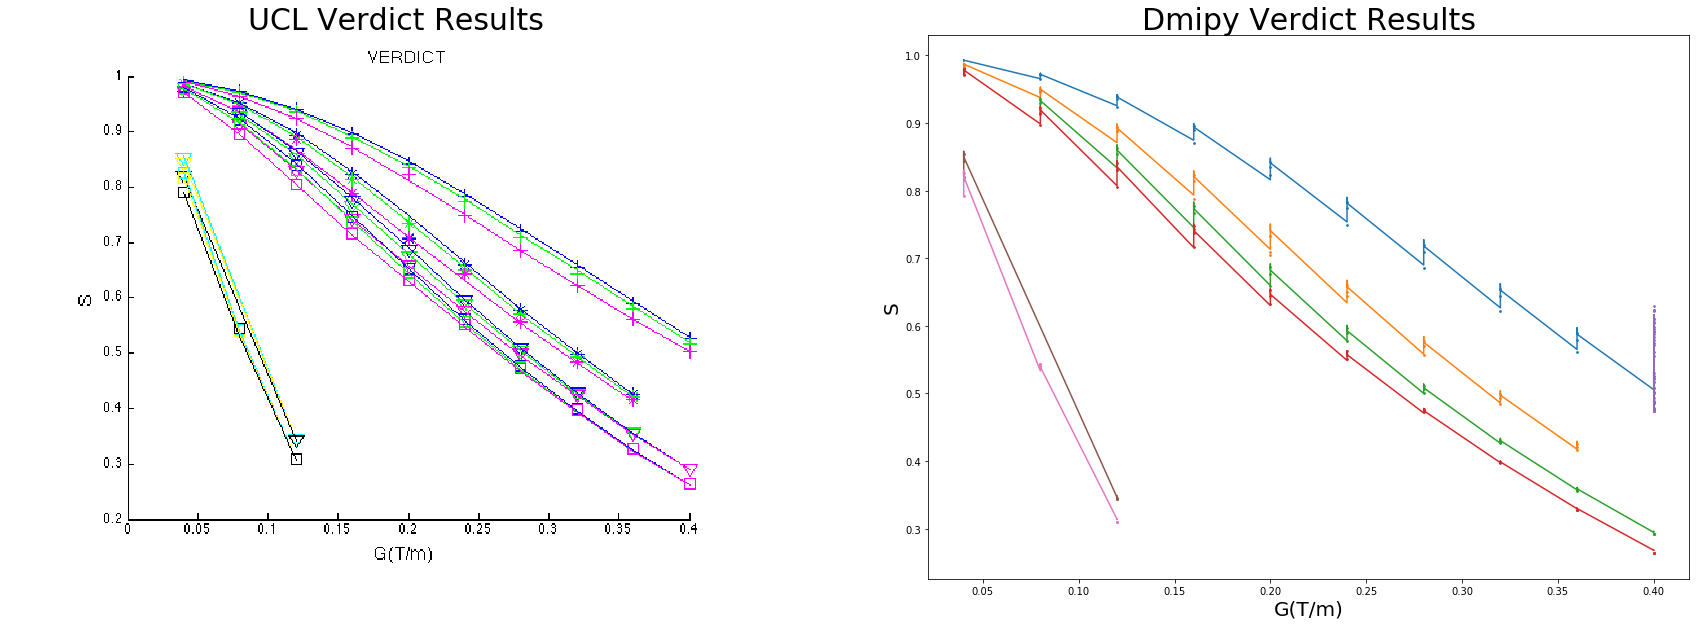

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.image as mpimg
img=mpimg.imread("http://camino.cs.ucl.ac.uk/uploads/Tutorials/VCLSsynth.png")
    
mask_nonzero = scheme.gradient_strengths>0.
G_nonzero = scheme.gradient_strengths[mask_nonzero]
Delta_nonzero = scheme.Delta[mask_nonzero]
delta_nonzero = scheme.delta[mask_nonzero]

predicted_data = verdict_fit.predict()[0]
predicted_data_nonzero = predicted_data[mask_nonzero]
data_nonzero = data[mask_nonzero]

fig, axs = plt.subplots(1, 2, figsize=[30, 10])
axs = axs.ravel()
axs[0].imshow(img)
axs[0].set_title('UCL Verdict Results', fontsize=30)
axs[0].axis('off')

for delta_, Delta_ in np.unique(np.c_[scheme.shell_delta, scheme.shell_Delta], axis=0):
    mask = np.all([Delta_nonzero == Delta_, delta_nonzero == delta_], axis=0)
    axs[1].plot(G_nonzero[mask], predicted_data_nonzero[mask])
    axs[1].scatter(G_nonzero[mask], data_nonzero[mask], s=3., marker='o')
axs[1].set_title('Dmipy Verdict Results', fontsize=30)
axs[1].set_xlabel('G(T/m)', fontsize=20)
axs[1].set_ylabel('S', fontsize=20);

While we didn't exactly duplicate their graph style, we can see that both the plots and signal fitting are very similar between Dmipy's and UCL's implementation.

Showing the fitting parameters, we can also see that Dmipy's estimate of the tumor cell diameter is 1.54e-5m, i.e. 15.4$\mu m$, which falls exactly within the ranges that Panagiotaki et al. reports.

In [9]:
verdict_fit.fitted_parameters

{'C1Stick_1_lambda_par': array([6.58332016e-09]),
 'C1Stick_1_mu': array([[ 2.12873298, -2.53619312]]),
 'S0': array([[1., 1., 1., 1., 1., 1.]]),
 'S4SphereGaussianPhaseApproximation_1_diameter': array([1.54025803e-05]),
 'partial_volume_0': array([0.76130392]),
 'partial_volume_1': array([0.09744434]),
 'partial_volume_2': array([0.14125174])}

## References
- Panagiotaki, Eletheria, et al. "Noninvasive quantification of solid tumor microstructure using VERDICT MRI." Cancer research 74.7 (2014): 1902-1912.
- Balinov, Balin, et al. "The NMR self-diffusion method applied to restricted diffusion. Simulation of echo attenuation from molecules in spheres and between planes." Journal of Magnetic Resonance, Series A 104.1 (1993): 17-25.
- Farooq, Hamza, et al. "Microstructure Imaging of Crossing (MIX) White Matter Fibers from diffusion MRI." Nature Scientific reports 6 (2016).